In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nbconvert import PythonExporter
import os
from tqdm import tqdm
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, log_loss
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionResNetV2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks


2025-09-05 10:49:00.409346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757069340.694427      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757069340.790405      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from keras.applications.inception_resnet_v2 import preprocess_input

#### Loading data ####

In [3]:
# adding the images, labels, styles 
file_path = "/kaggle/input/data-sampling10000-topstyles10/data_sampling10000_topstyles10.csv"
df = pd.read_csv(file_path)
df.head()

,artist,style,movement,tags,url,img,file_name,genre_list,Artwork,Date
0,Panayiotis Tetsis,Impressionism,Post-Impressionism,NaN,https://www.wikiart.org/en/panayiotis-tetsis/s...,https://uploads3.wikiart.org/images/panayiotis...,127519-sunset.jpg,['cloudscape'],NaN,NaN
1,Henry Scott Tuke,Impressionism,Impressionism,"['Fun', 'Vacation', 'summer']",https://www.wikiart.org/en/henry-scott-tuke/th...,https://uploads5.wikiart.org/00261/images/henr...,100529-henry-scott-tuke-the-bathers-1922.jpg,['genre painting'],NaN,NaN
2,Alfred Sisley,Impressionism,Impressionism,"['fires-and-floods', 'forests-and-trees', 'Ban...",https://www.wikiart.org/en/alfred-sisley/the-f...,https://uploads1.wikiart.org/images/alfred-sis...,92312-the-flood-on-the-road-to-saint-germain-1...,['landscape'],NaN,NaN
3,Camille Pissarro,Impressionism,Impressionism,"['Grassland', 'Meadow', 'Pasture', 'Plain']",https://www.wikiart.org/en/camille-pissarro/ro...,https://uploads2.wikiart.org/images/camille-pi...,90106-rolling-landscape-in-winter-1875.jpg,['landscape'],NaN,NaN
4,Guy Rose,Impressionism,Impressionism,"['seas-and-oceans', 'cliffs-and-rocks', 'Bank'...",https://www.wikiart.org/en/guy-rose/grey-after...,https://uploads3.wikiart.org/images/guy-rose/g...,104411-grey-afternoon.jpg,['landscape'],NaN,NaN


In [4]:
df.shape

(10000, 10)

In [5]:
list_images= df['file_name'].unique().tolist()

#### Loading and resize images ####

In [6]:
def load_and_resize_images(list_images):

    images_list = []
    
    for filename in list_images:
            img_path = os.path.join("/kaggle/input/wikiart-all-artpieces/wikiart/wikiart", filename)
            img = Image.open(img_path).convert('RGB')

            img_resized = img.resize((224, 224), Image.BICUBIC)

            img_array = np.array(img_resized)

            image_preprocessed = preprocess_input(img_array)
            # convert into an array and add to list 
            images_list.append(image_preprocessed)
    
    # Convertir la liste en tableau NumPy
    images_np = np.stack(images_list)
    return images_np

In [7]:
images_np = load_and_resize_images(list_images)

#### Define X and y ####

In [8]:
X = images_np

In [9]:
y = df['style']

In [10]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (10000, 224, 224, 3)
y shape: (10000,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,      
    random_state=42,
    stratify=y
)

#### Encode labels ####

In [12]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [13]:
### Encoding the labels
y_train_cat = to_categorical(y_train_encoded, 10).astype('float32')
y_test_cat = to_categorical(y_test_encoded, 10).astype('float32')

In [14]:
def set_nontrainable_layers(model):

    # Set the first layers to be untrainable
    model.trainable = False

    return model

In [17]:
def load_model():
    model = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    return model


In [18]:
model = load_model()
model = set_nontrainable_layers(model)
model.summary()

I0000 00:00:1757069630.750778      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757069630.751423      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "inception_resnet_v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 54,336,736 (207.28 MB)

In [19]:

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer1 = layers.Dense(500, activation='relu')
    dense_layer2 = layers.Dense(250, activation='relu')
    dense_layer3 = layers.Dense(150, activation='relu')


    prediction_layer = layers.Dense(10, activation='softmax')
    
    
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer1,
        dense_layer2,
        dense_layer3,
        prediction_layer
    ])
    return model

In [20]:
model = add_last_layers(model)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │    19,200,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 150)            │        37,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,701,646 (281.15 MB)

 Trainable params: 19,364,910 (73.87 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [21]:
def build_model():
    # $CHALLENGIFY_BEGIN    
    model = load_model()
    model = add_last_layers(model)
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [22]:
model = build_model()

#### Model checkpoint ####

In [23]:
### CHANGE THE NAME WITH THE NAME OF THE MODEL YOU TRIED AND NUMBER OF IMAGES
model_checkpoint = callbacks.ModelCheckpoint("0.keras", monitor='val_loss', verbose=0, save_best_only=True)

#### ReduceLROnPlateau ####

In [24]:
#Reduce the learning rate when the model stops improving
#lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0)
#exponential = 

#### EarlyStopping ####

In [25]:
es = EarlyStopping(monitor = 'val_loss', 
                   patience = 20, 
                   verbose = 1, 
                   restore_best_weights = True)

history = model.fit(X_train, y_train_cat, 
                    validation_split=0.3, 
                    epochs=50, 
                    batch_size=16, 
                    callbacks=[es, model_checkpoint])

Epoch 1/50


I0000 00:00:1757069674.105966     106 service.cc:148] XLA service 0x7bb904004d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757069674.107089     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757069674.107120     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757069678.579416     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/307 ━━━━━━━━━━━━━━━━━━━━ 3:07:34 37s/step - accuracy: 0.1250 - loss: 2.8219

I0000 00:00:1757069685.671116     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


307/307 ━━━━━━━━━━━━━━━━━━━━ 101s 208ms/step - accuracy: 0.2908 - loss: 2.0920 - val_accuracy: 0.4238 - val_loss: 1.5960
Epoch 2/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.5457 - loss: 1.2584 - val_accuracy: 0.4348 - val_loss: 1.6101
Epoch 3/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.6928 - loss: 0.8750 - val_accuracy: 0.4448 - val_loss: 1.6917
Epoch 4/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.8318 - loss: 0.5479 - val_accuracy: 0.4395 - val_loss: 1.9196
Epoch 5/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - accuracy: 0.9213 - loss: 0.2956 - val_accuracy: 0.4538 - val_loss: 1.8801
Epoch 6/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.9649 - loss: 0.1776 - val_accuracy: 0.4390 - val_loss: 2.0759
Epoch 7/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.9898 - loss: 0.0755 - val_accuracy: 0.4310 - val_loss: 2.3324
Epoch 8/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.9996 - loss: 0.0299 - va

#### Evaluating the model ####

In [26]:
model.evaluate(X_test, y_test_cat, return_dict=True)

94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 233ms/step - accuracy: 0.4276 - loss: 1.5892


{'accuracy': 0.42133334279060364, 'loss': 1.6104432344436646}

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

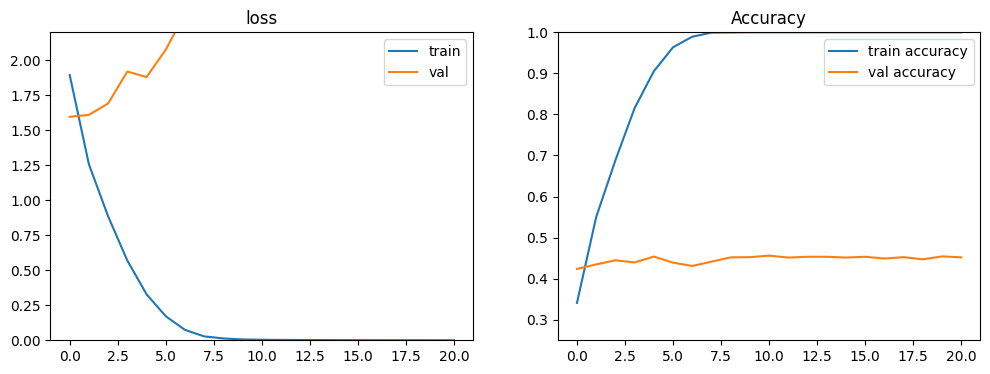

In [27]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()
    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)
plot_history(history)

#### Testing ####

In [28]:
images_paths = ["/kaggle/input/images-to-try/Paul_Czanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg",
                "/kaggle/input/images-to-try/Piet_Mondriaan_1942_-_New_York_City_I.jpg",
                "/kaggle/input/images-to-try/Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg",
                "/kaggle/input/images-to-try/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"]

In [29]:
images_list = []

for img_path in images_paths :
            img = Image.open(img_path).convert('RGB')

            img_resized = img.resize((224, 224), Image.BICUBIC)

            img_array = np.array(img_resized)

            image_preprocessed = preprocess_input(img_array)
            # convert into an array and add to list 
            images_list.append(image_preprocessed)
    
images_np = np.stack(images_list)

In [30]:
X_eval = images_np

In [31]:
X_eval.shape

(4, 224, 224, 3)

In [32]:
preds = model.predict(X_eval)
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
[[2.8187397e-03 1.5158355e-02 1.3724245e-01 3.0215830e-02 2.8338227e-03
  6.9842005e-01 4.5728400e-02 4.2263987e-03 3.0504474e-02 3.2851502e-02]
 [5.6818014e-01 2.3529243e-02 1.2923127e-01 1.8576100e-02 7.7780946e-03
  8.1949189e-02 1.0378331e-02 5.4342747e-03 8.7729886e-02 6.7213409e-02]
 [6.7801954e-04 1.9388746e-03 4.6641819e-02 5.7842772e-02 4.7599411e-01
  3.7062760e-02 9.7835191e-02 1.9317670e-01 2.2611529e-02 6.6218190e-02]
 [5.5437976e-01 4.0455409e-03 2.1186751e-01 1.9799320e-03 1.3407714e-03
  3.1863946e-02 1.0243435e-03 3.3992794e-04 1.1456219e-01 7.8596100e-02]]


In [33]:
# indices
pred_indices = preds.argmax(axis=1)
# label
pred_labels = le.inverse_transform(pred_indices)
pred_labels

array(['Post-Impressionism', 'Abstract Expressionism', 'Neoclassicism',
       'Abstract Expressionism'], dtype=object)

In [34]:
for img_name, label, pred in zip(images_paths, pred_labels, preds):
    print(f"{img_name} : {label} ({pred.max():.2f})")

/kaggle/input/images-to-try/Paul_Czanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg : Post-Impressionism (0.70)
/kaggle/input/images-to-try/Piet_Mondriaan_1942_-_New_York_City_I.jpg : Abstract Expressionism (0.57)
/kaggle/input/images-to-try/Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg : Neoclassicism (0.48)
/kaggle/input/images-to-try/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg : Abstract Expressionism (0.55)
